In [1]:
"""
Preamble for most code and jupyter notebooks
@author: tobinsouth
@notebook date: May 19, 2023
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import math, string, re, pickle, json, os, sys, datetime, itertools
from collections import Counter
from tqdm import tqdm
from tueplots import bundles
plt.rcParams.update({**bundles.neurips2022(), 'figure.dpi': 300.0})
plt.rcParams.update({'text.usetex': True, 'figure.dpi': 400.0})

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
c1 = "#FF5E5B"
c2 = '#433633'
c3 = '#2F3737'
c4 = '#FCE19C'
c5 = '#8BB174'

palette = ['#FF5E5B', '#FE7850', '#FE9250', '#FDAC50', '#FCE19C']

In [3]:
# Variables for Cuqbiq + FB SCI data
locations = {
    "16980": "chicago",
    "35620": "nyc",
    "31080": "la",
    "19100": "dallas",
    "14460": "boston",
    }

ghns = ['geohash9','geohash8','geohash7','geohash6','geohash5','geohash4','geohash3']

# FB SCI + Gravity + Cuebiq PSI

In [4]:
all_PSI_SCI_gravity = {}
for regioncode, name in locations.items():
    all_PSI_SCI_gravity[name] = pd.read_csv(f'results/all_PSI_SCI_gravity_{regioncode}.csv.gz', compression='gzip')

In [5]:
# Baseline lines
FBCBQ_results = {}
for regioncode, name in locations.items():
    PSI_SCI_gravity = all_PSI_SCI_gravity[name]
    FBCBQ_results[name] = {}
    person_results = PSI_SCI_gravity.corr('pearson')
    FBCBQ_results[name]['pearson_gravity'] = person_results['gravity']['log_sci']
    FBCBQ_results[name]['pearson_gravity15'] = person_results['gravity1.5']['log_sci']
    FBCBQ_results[name]['pearson_gravity1'] = person_results['gravity1']['log_sci']
    FBCBQ_results[name]['pearson_gravity_nolog'] = person_results['gravity']['scaled_sci']
    FBCBQ_results[name]['pearson_gravity15_nolog'] = person_results['gravity1.5']['scaled_sci']
    FBCBQ_results[name]['pearson_gravity1_nolog'] = person_results['gravity1']['scaled_sci']

    pearson_log = PSI_SCI_gravity.corr('pearson')['log_sci']
    pearson_normal = PSI_SCI_gravity.corr('pearson')['scaled_sci']
    spearman = PSI_SCI_gravity.corr('spearman')['log_sci']

    FBCBQ_results[name]['spearman_mean'] = [spearman[ghn] for ghn in sorted(ghns)]
    FBCBQ_results[name]['pearson_mean'] = [pearson_normal[ghn] for ghn in sorted(ghns)]
    FBCBQ_results[name]['pearson_mean_log'] = [pearson_log[ghn] for ghn in sorted(ghns)]
    FBCBQ_results[name]['pearson_log_log'] = [pearson_log[ghn] for ghn in ['log_'+ghn for ghn in sorted(ghns)]]

    FBCBQ_results[name]['pearson_filtered'] = [pearson_normal[ghn] for ghn in ['filtered_'+ghn for ghn in sorted(ghns)]]
    FBCBQ_results[name]['pearson_median'] = [pearson_normal[ghn] for ghn in ['median_'+ghn for ghn in sorted(ghns)]]

In [6]:
FBCBQ_results.keys()

dict_keys(['chicago', 'nyc', 'la', 'dallas', 'boston'])

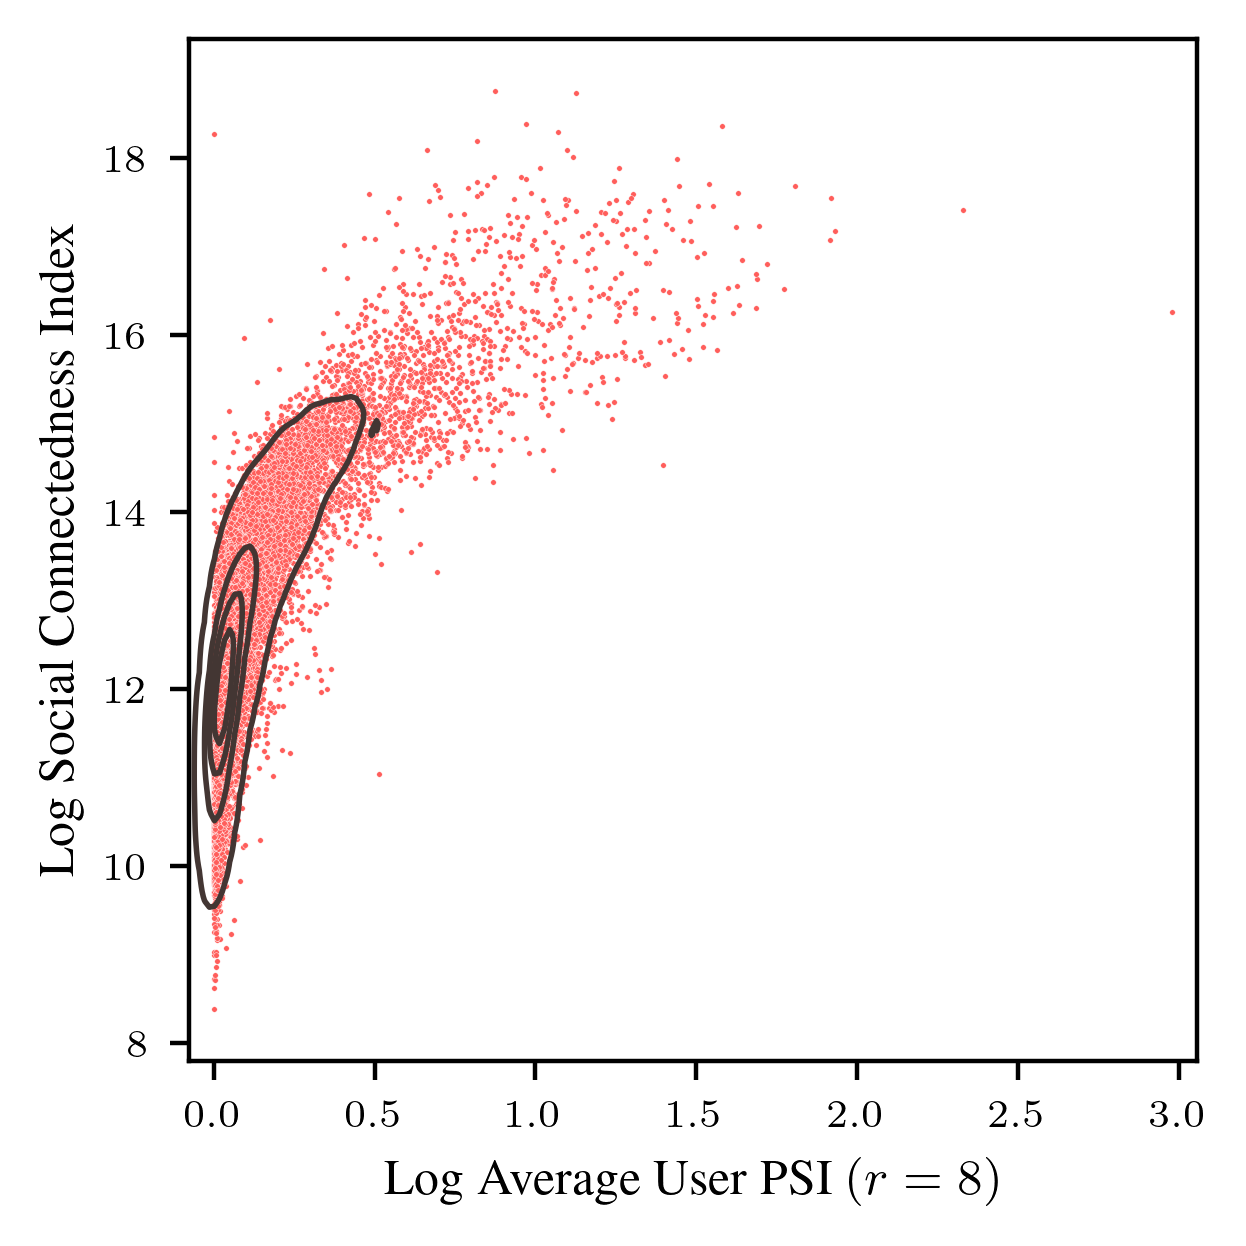

In [7]:
PSI_SCI_w_o_0 = all_PSI_SCI_gravity['boston'].copy()
PSI_SCI_w_o_0[PSI_SCI_w_o_0['log_sci'] < 2] = np.nan

def psi_sci_scatter(ax):
    sns.scatterplot(data=PSI_SCI_w_o_0, x='log_geohash8', y='log_sci', s=1, alpha=1, linewidths=0, rasterized=True, color=c1, ax=ax)
    sns.kdeplot(data=PSI_SCI_w_o_0, x='log_geohash8', y='log_sci', levels=5, color=c2, linewidths=1, ax=ax)
    ax.set_xlabel('Log Average User PSI $(r=8)$')
    ax.set_ylabel('Log Social Connectedness Index')

fig, ax = plt.subplots(1,1, figsize=(3,3))
psi_sci_scatter(ax)

In [8]:
[d['pearson_gravity'] for d in FBCBQ_results.values()]

[0.12831622024886924,
 0.10726579238223087,
 0.27746584353280024,
 0.24235637172614138,
 0.15595698561136243]

In [9]:
np.mean([d['pearson_gravity'] for d in FBCBQ_results.values()])

0.1822722427002808

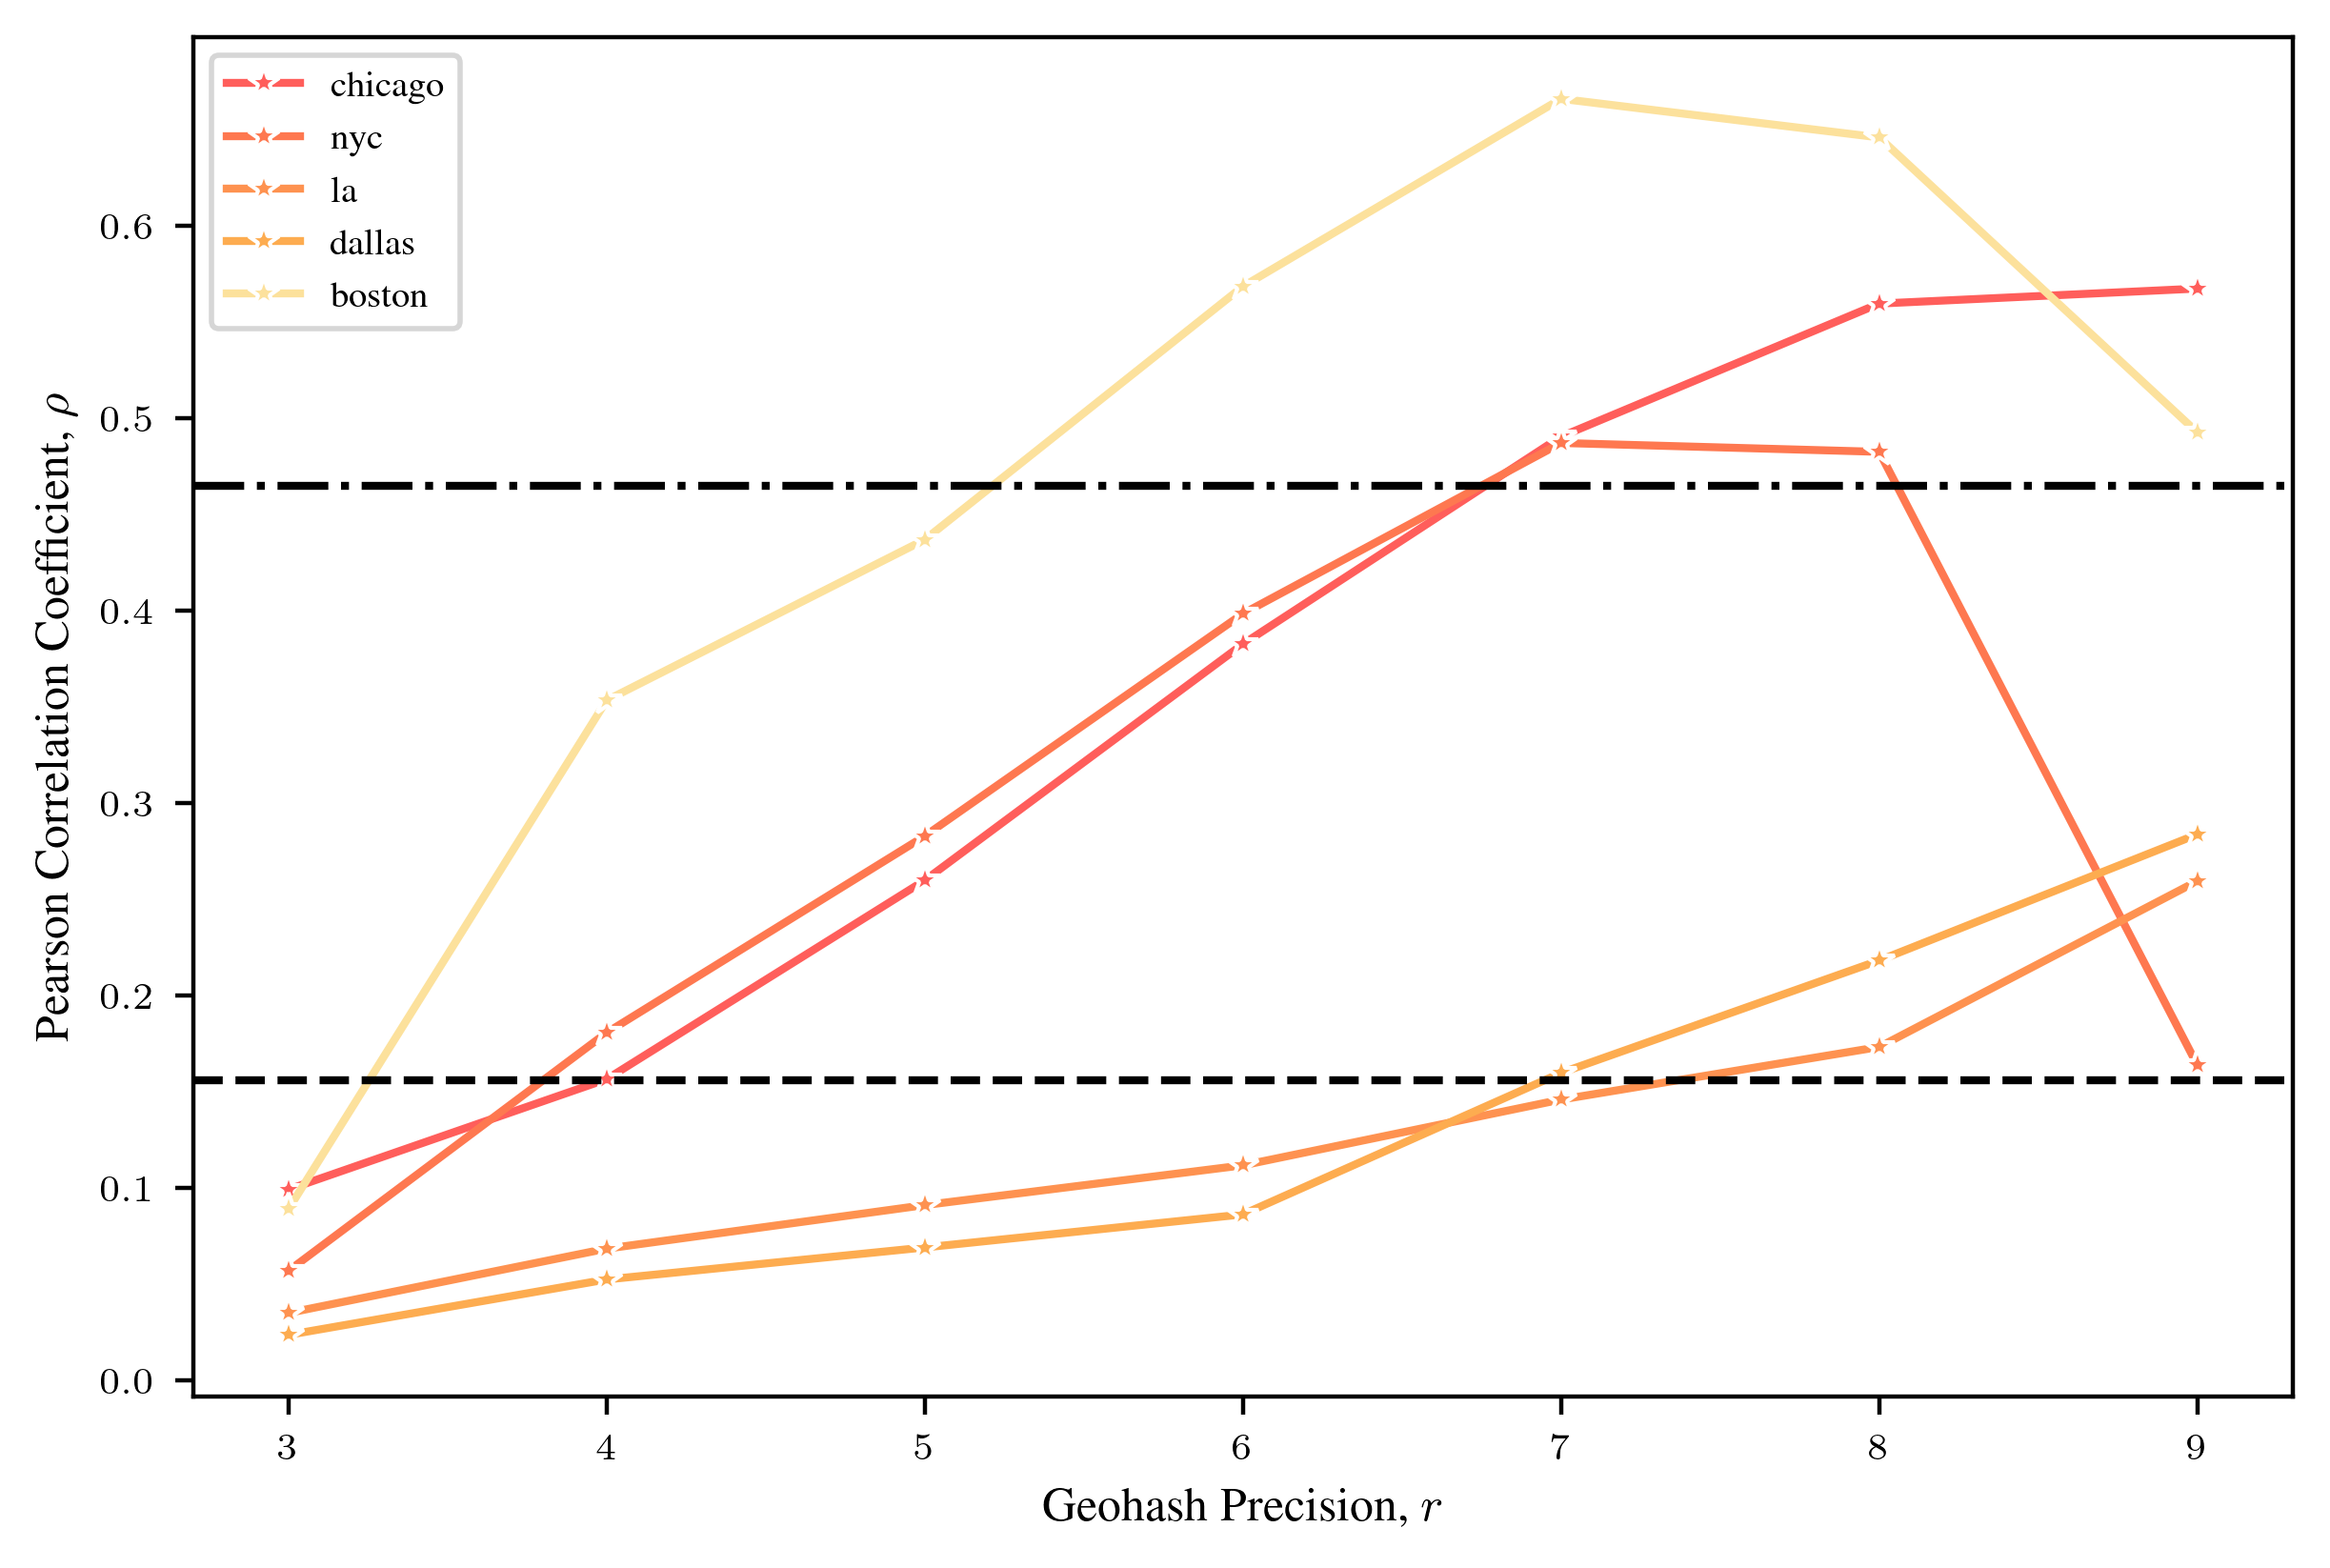

In [10]:
def psi_lineplot(ax):
    for i, (name, linedata) in enumerate(FBCBQ_results.items()):
        sns.lineplot(x=range(3,10), y=linedata['pearson_mean'], marker='*', label=name, ax=ax, color=palette[i])
        # sns.lineplot(x=range(3,10), y=linedata['pearson_log_log'], marker='^',  label = name, ax=ax, color=palette[i])
        # label='$SCI \sim Geohash Intersection$', 

    # label='$log(SCI) \sim log(Geohash Intersection)$',
    ax.axhline(linedata['pearson_gravity'], color='black', linestyle='--', label=f'$log(SCI) \sim 1/d^{2}$')
    ax.axhline(linedata['pearson_gravity1'], color='black', linestyle='-.', label=f'$log(SCI) \sim 1/d$)')


    # ax.set_xticks(np.arange(len(ghns)))
    # ax.set_xticklabels(list(range(3, 10)))
    ax.set_ylabel('Pearson Correlation Coefficient, $\\rho$')
    ax.set_xlabel('Geohash Precision, $r$')
    # ax.legend()

fig, ax = plt.subplots(figsize=(6, 4))
psi_lineplot(ax)

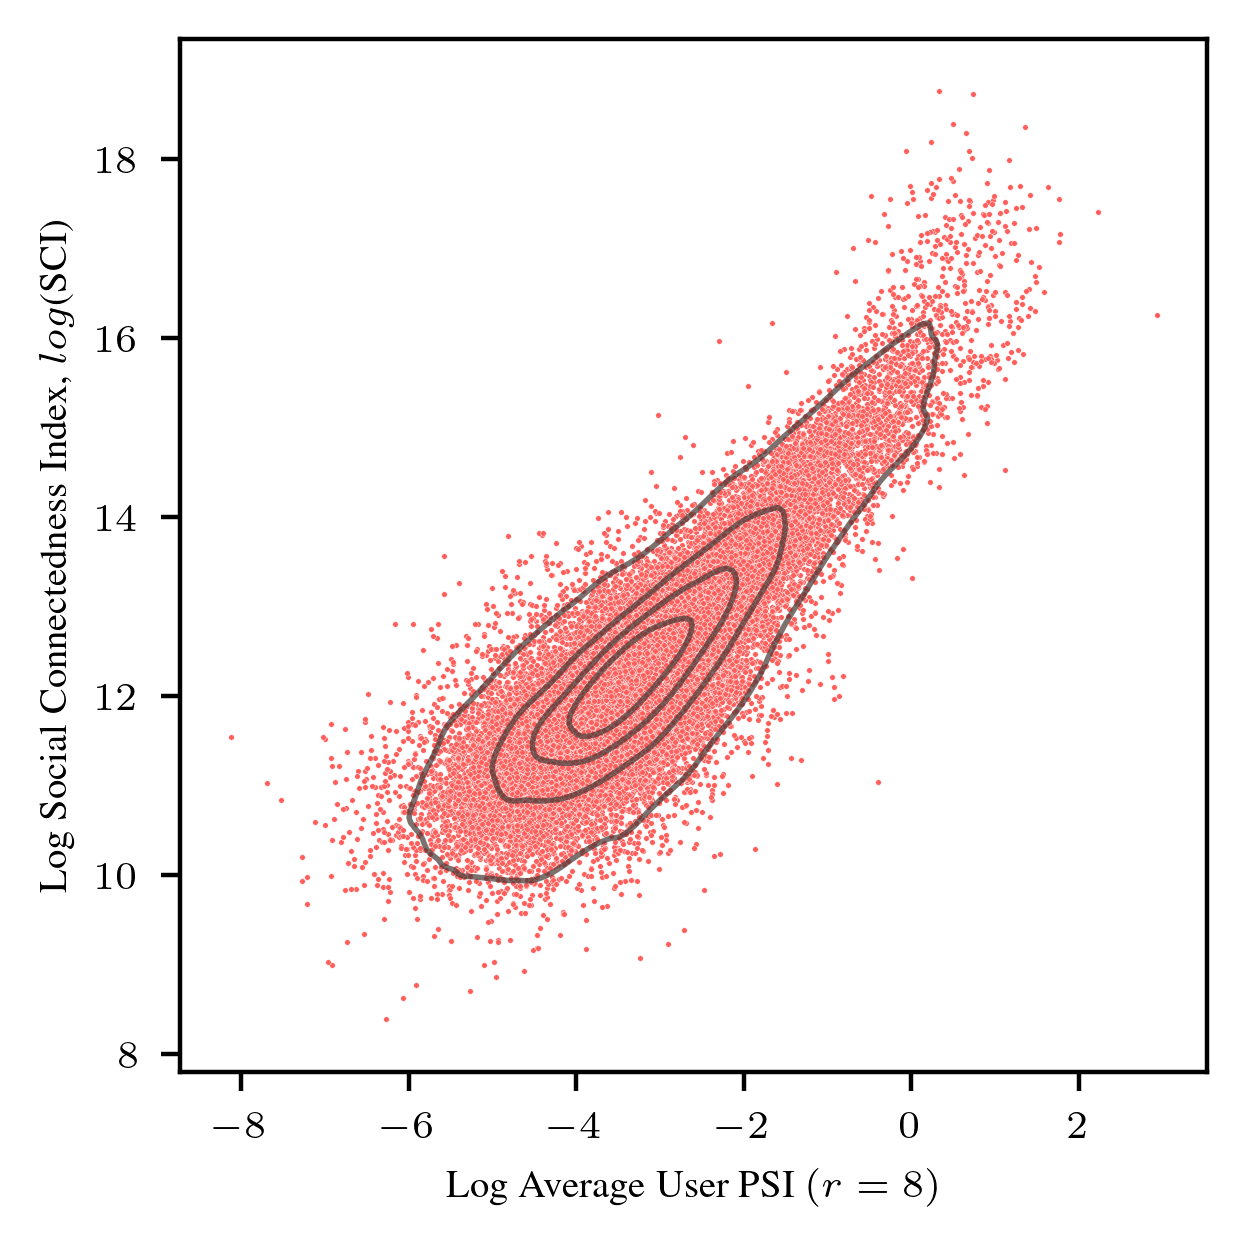

In [32]:
all_PSI_SCI_gravity = pd.read_csv('results/all_PSI_SCI_gravity.csv.gz', compression='gzip')
all_PSI_SCI_gravity['gravity1'] = 1 / all_PSI_SCI_gravity['distance']
# Baseline lines
person_results = all_PSI_SCI_gravity.corr('pearson')
pearson_gravity = person_results['gravity']['log_sci']
pearson_gravity15 = person_results['gravity1.5']['log_sci']
pearson_gravity1 = person_results['gravity1']['log_sci']
pearson_gravity_nolog = person_results['gravity']['scaled_sci']
pearson_gravity15_nolog = person_results['gravity1.5']['scaled_sci']
pearson_gravity1_nolog = person_results['gravity1']['scaled_sci']

pearson_log = all_PSI_SCI_gravity.corr('pearson')['log_sci']
pearson_normal = all_PSI_SCI_gravity.corr('pearson')['scaled_sci']
spearman = all_PSI_SCI_gravity.corr('spearman')['log_sci']

spearman_mean = [spearman[ghn] for ghn in sorted(ghns)]
pearson_mean = [pearson_normal[ghn] for ghn in sorted(ghns)]
pearson_mean_log = [pearson_log[ghn] for ghn in sorted(ghns)]
pearson_log_log = [pearson_log[ghn] for ghn in ['log_'+ghn for ghn in sorted(ghns)]]

pearson_filtered = [pearson_normal[ghn] for ghn in ['filtered_'+ghn for ghn in sorted(ghns)]]
pearson_median = [pearson_normal[ghn] for ghn in ['median_'+ghn for ghn in sorted(ghns)]]


def psi_sci_scatter(ax):
    sns.scatterplot(data=all_PSI_SCI_gravity, x='log_geohash8', y='log_sci', s=1, alpha=1, linewidths=0, rasterized=True, color=c1, ax=ax)
    sns.kdeplot(data=all_PSI_SCI_gravity, x='log_geohash8', y='log_sci', levels=5, color=c2, alpha=0.7, linewidths=1, ax=ax)
    ax.set_xlabel('Log Average User PSI $(r=8)$', fontsize=7)
    ax.set_ylabel('Log Social Connectedness Index, $log$(SCI)', fontsize=7)

fig, ax = plt.subplots(1,1, figsize=(3,3))
psi_sci_scatter(ax)

<>:2: DeprecationWarning: invalid escape sequence '\s'
<>:3: DeprecationWarning: invalid escape sequence '\s'
<>:5: DeprecationWarning: invalid escape sequence '\s'
<>:6: DeprecationWarning: invalid escape sequence '\s'
<>:8: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\s'
<>:17: DeprecationWarning: invalid escape sequence '\s'
<>:2: DeprecationWarning: invalid escape sequence '\s'
<>:3: DeprecationWarning: invalid escape sequence '\s'
<>:5: DeprecationWarning: invalid escape sequence '\s'
<>:6: DeprecationWarning: invalid escape sequence '\s'
<>:8: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\s'
<>:17: DeprecationWarning: invalid escape sequence '\s'
/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_32457/2816793754.py:2: DeprecationWarning: invalid escape sequence '\s'
  ax.plot(range(3,10), pearson_mean, marker='s', ms=7, lw=2, label='SCI $\sim$ GI', color=c1)
/va

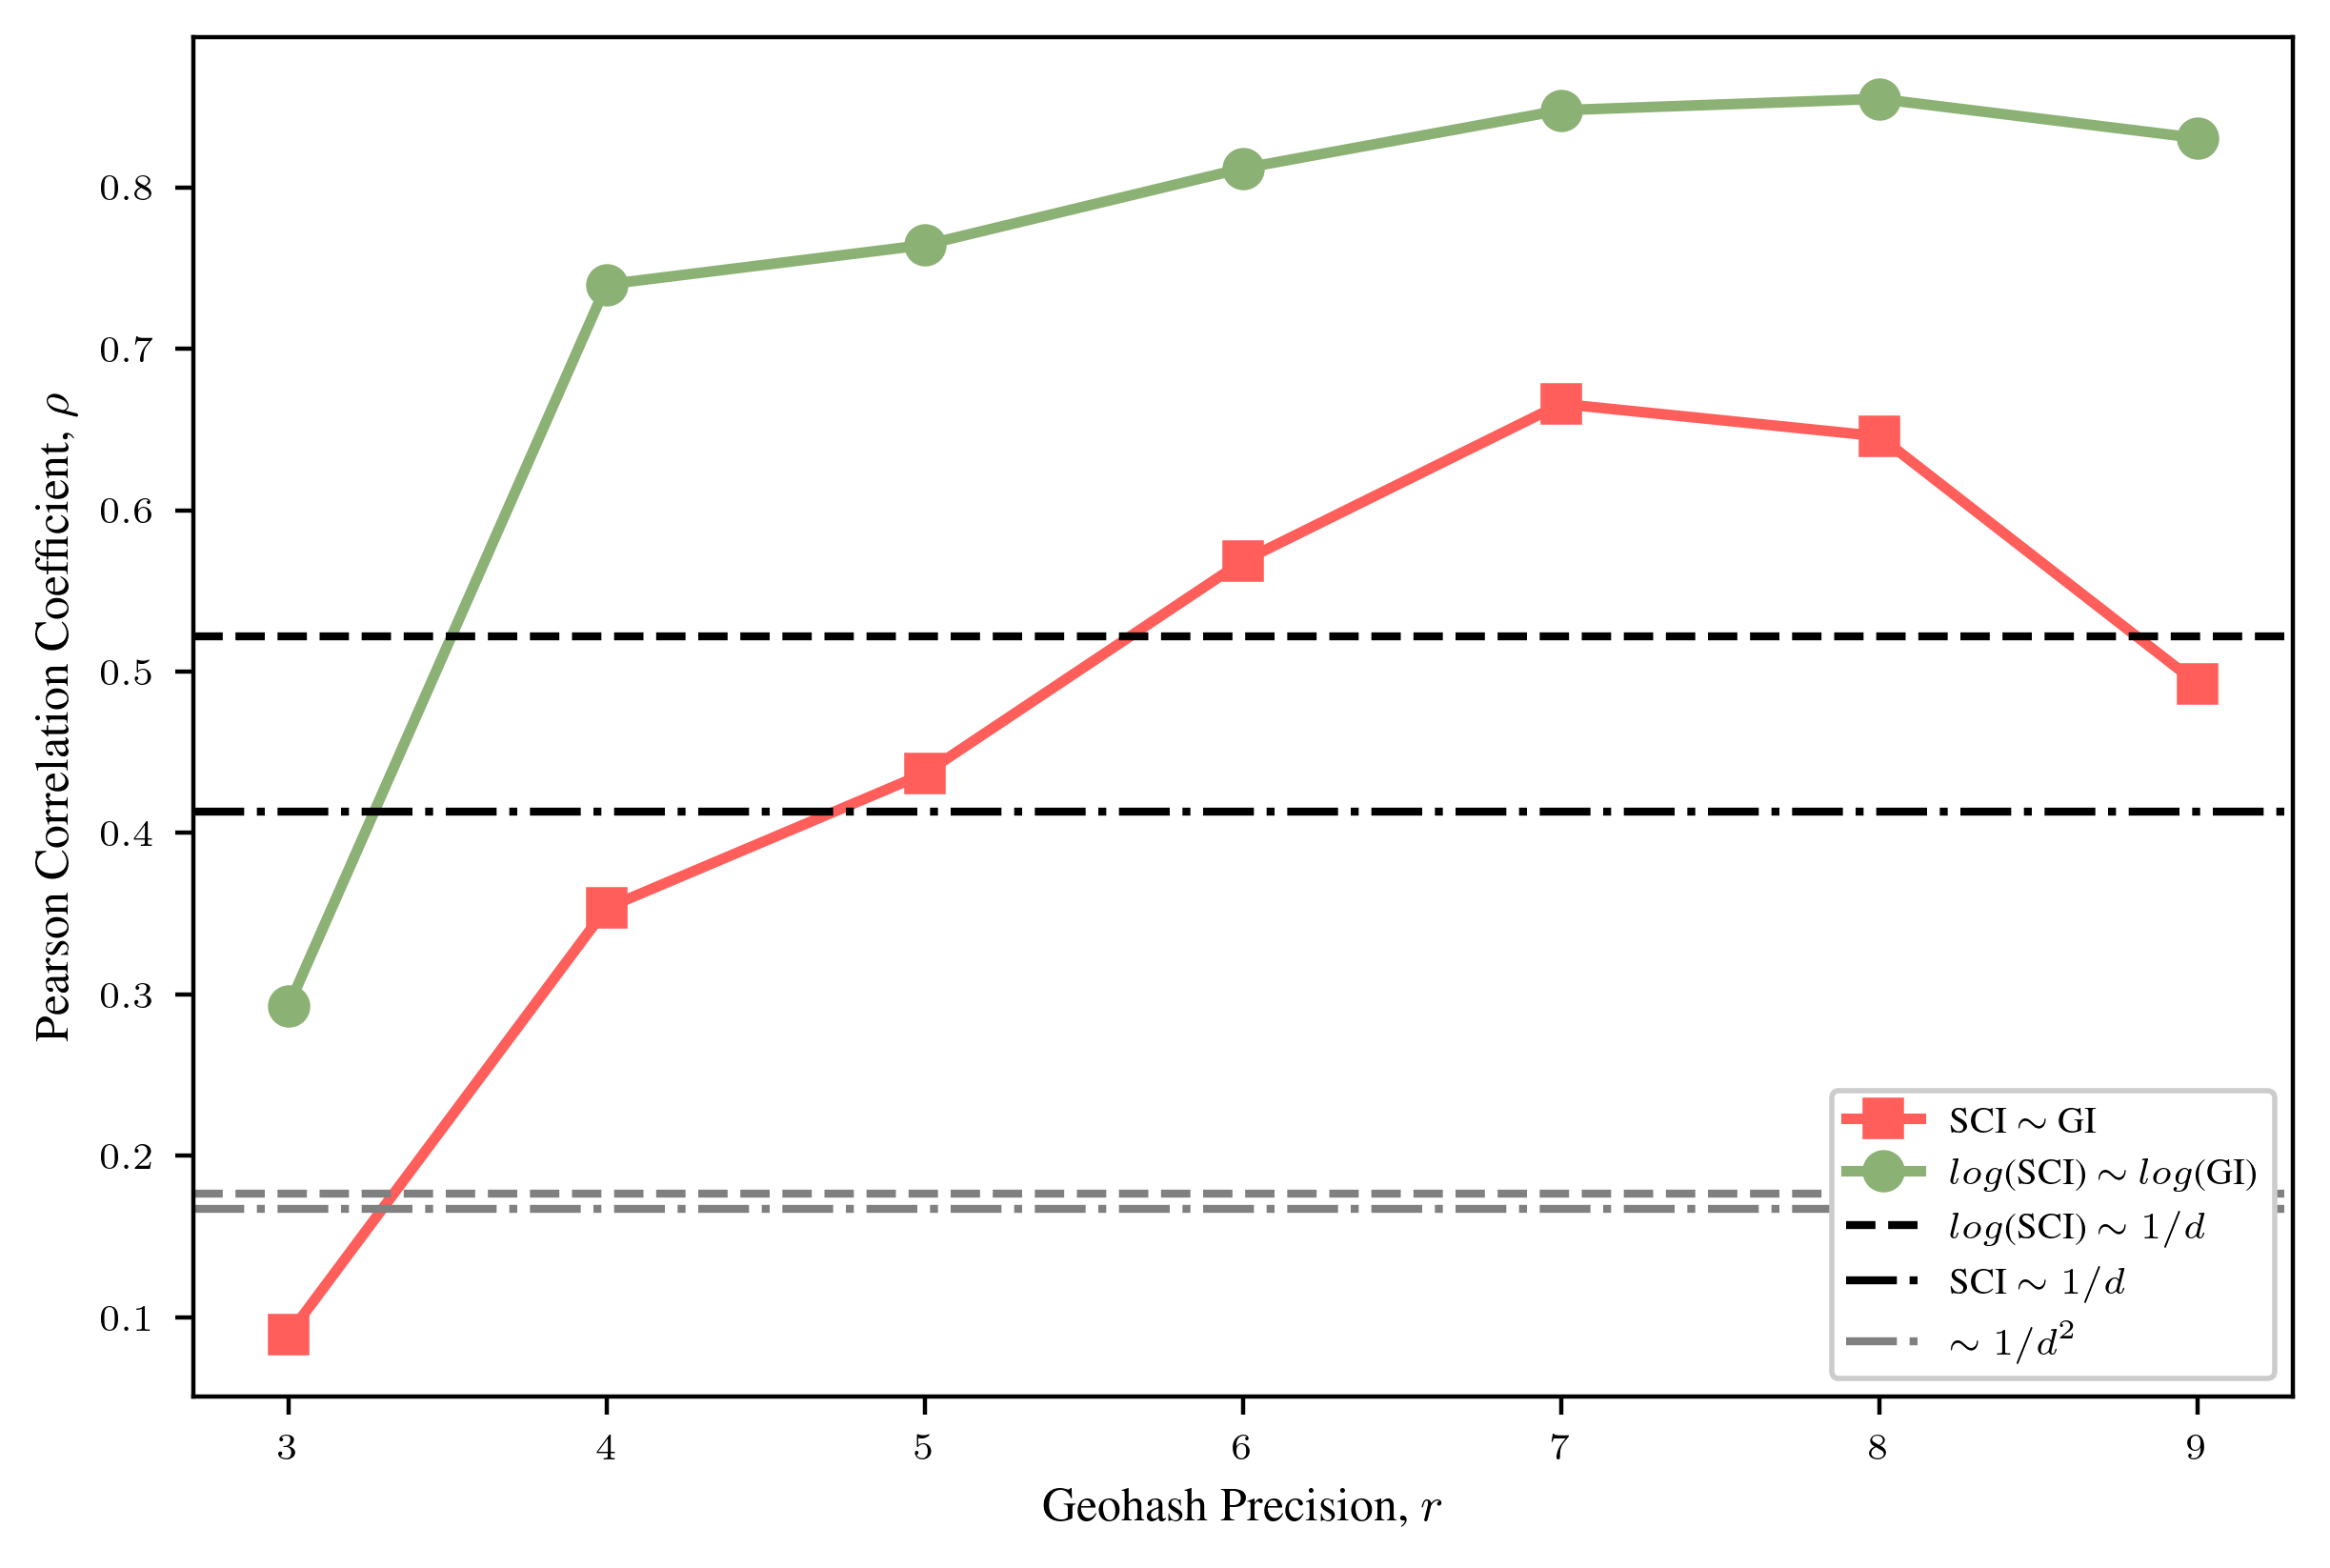

In [34]:
def psi_lineplot(ax):
    ax.plot(range(3,10), pearson_mean, marker='s', ms=7, lw=2, label='SCI $\sim$ GI', color=c1)    
    ax.plot(range(3,10), pearson_log_log, ms=7, lw=2, marker='o', label='$log$(SCI) $\sim$ $log$(GI)', color=c5)

    ax.axhline(pearson_gravity1, color='black', linestyle='--', label=f'$log$(SCI) $\sim 1/d$')
    ax.axhline(pearson_gravity1_nolog, color='black', linestyle='-.', label=f'SCI $\sim 1/d$')

    ax.axhline(pearson_gravity, color='grey', linestyle='--', label=f'$log$(SCI) $\sim 1/d^{2}$')
    ax.axhline(pearson_gravity_nolog, color='grey', linestyle='-.', label=f'SCI $\sim 1/d^{2}$')

    ax.set_ylabel('Pearson Correlation Coefficient, $\\rho$')
    ax.set_xlabel('Geohash Precision, $r$')

    # remove the last two legend items
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[:-2] + [handles[-1]]
    labels = labels[:-2] + ['$\sim 1/d^{2}$']

    legend = ax.legend(handles=handles, labels=labels, fontsize=7, loc='lower right')
    legend.get_frame().set_alpha(1)


fig, ax = plt.subplots(figsize=(6, 4))
psi_lineplot(ax)

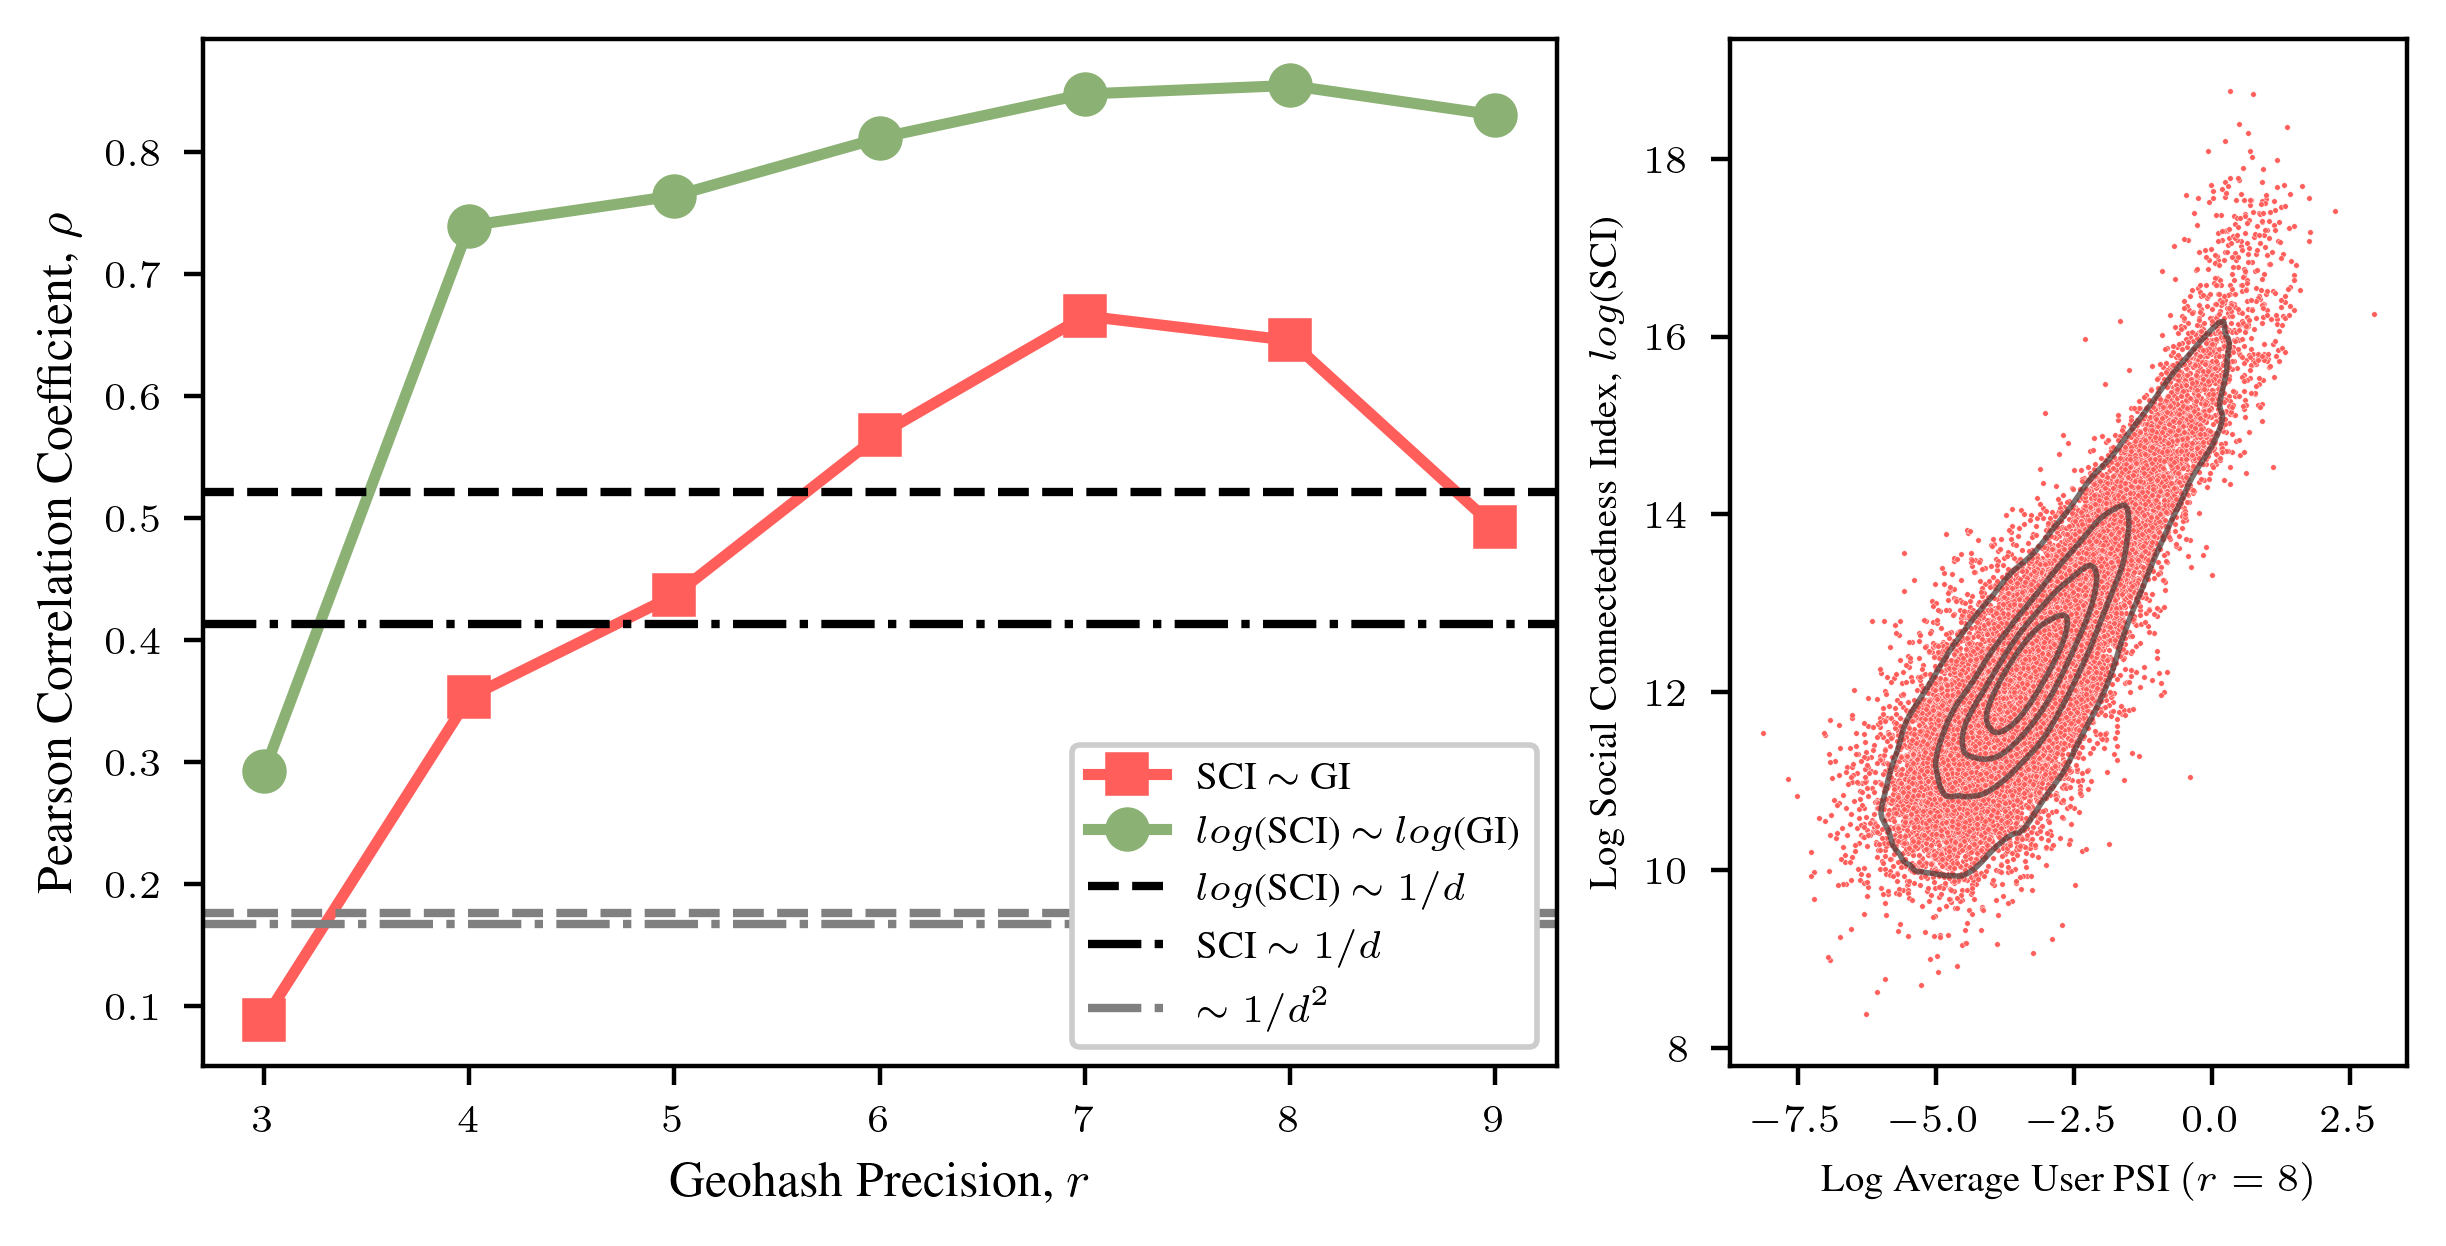

In [35]:
# Make a figure with psi_lineplot on the left for two thirds and psi_sci_scatter on the right for one third as a box.
fig, ax = plt.subplots(1,2, figsize=(6,3), gridspec_kw={'width_ratios': [2, 1]})
psi_lineplot(ax[0])
psi_sci_scatter(ax[1])

# Friends and Family

In [14]:
# read in corr_values from pickle
with open('results/corr_values.pickle', 'rb') as handle:
    data = pickle.load(handle)

corr_values = data['corr_values']
corr_values_already_friends = data['corr_values_already_friends']
best_all_df = data['best_all_df']

In [15]:
import libgeohash as gh


# Prettymaps
from prettymaps import *
# Vsketch
import vsketch
# OSMNX
import osmnx as ox
# Matplotlib-related
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
from descartes import PolygonPatch
import matplotlib.patches as patches
import geopandas as gpd


# Shapely
from shapely.geometry import *
from shapely.affinity import *
from shapely.ops import unary_union

# Style parameters
background_c = '#ffffff' #'#F2F4CB'
dilate = 100
center = (42.361358642578125, -71.09184265136719)
radius = 600

In [16]:
# We're gonna manually draw the geohash grid by picking which geohashes
def get_geohash_grid(geo, depth=1, lw=1, showtext=True):
    neighbours_on_edge, neighbours_inside = list(gh.neighbors(geo).values()), [geo]
    for i in range(depth):
        temp_neighbours = []
        for neighbour in neighbours_on_edge:
            temp_neighbours.extend(list(gh.neighbors(neighbour).values()))
        neighbours_inside.extend(neighbours_on_edge)
        neighbours_on_edge = set([geo for geo in temp_neighbours if geo not in neighbours_inside])
    return neighbours_inside
    
all_geohashes_to_draw_big = get_geohash_grid(gh.encode(center[0], center[1], precision=6), depth=1)
all_geohashes_to_draw_medium = get_geohash_grid(gh.encode(center[0], center[1], precision=7), depth=20)
all_geohashes_to_draw_small = get_geohash_grid(gh.encode(center[0], center[1], precision=8), depth=50)

In [17]:
central_geo_6 = gh.encode(center[0], center[1], precision=6)
neighbors = gh.neighbors(central_geo_6)
all_geohashes_to_draw_small = [geo for geo in all_geohashes_to_draw_small if geo[:-2] in [neighbors['s'], neighbors['se'], neighbors['sw']]]
all_geohashes_to_draw_medium = [geo for geo in all_geohashes_to_draw_medium if geo[:-1] in [central_geo_6, neighbors['e'], neighbors['w'], 
                                                                                          neighbors['s'], neighbors['se'], neighbors['sw']]]

In [18]:
def plot_performance_graph(ax, old=True):
    x = range(3,10)
    ax.plot(x, [v.loc['intersection_size', 'friendship'] for r,v in corr_values.items()], 'o-', 
    label='GI $\sim$ Friendship', lw=2, ms=7, c=palette[2])
    ax.plot(x, [v.loc['intersection_size', 'friendship'] for r,v in corr_values_already_friends.items()], 's-', 
    label='GI $\sim$ Friendship (Existing Friends)', lw=2, ms=7, c= c1)
    # ax.plot(x, [v.loc['log_intersection', 'friendship'] for r,v in corr_values.items()], 'o-', 
    # label='Log GI $\sim$ Friendship')
    ax.plot(x, [v.loc['intersection_size', 'communications'] for r,v in corr_values.items()], 'o-', 
    label='GI $\sim$ Communications', lw=2, ms=7, c=c4)
    ax.plot(x, [v.loc['intersection_size', 'proximity'] for r,v in corr_values.items()], 'o-', 
    label='GI $\sim$ Bluetooth Proximity', lw=2, ms=7, c=c5)
    ax.plot(x, [v.loc['friendship', 'proximity'] for r,v in corr_values.items()],  '--', 
    label='Bluetooth Proximity $\sim$ Friendship', lw=2, ms=7, c=c2)

    if old == True:
        ax.set_ylim(0, 0.4)
        ax.legend(bbox_to_anchor=(0.5,-0.6), loc='lower center', fontsize=7)
        ax.set_xlabel('Geohash Precision, $r$')
        ax.set_ylabel('Pearson Correlation Coefficient, $\\rho$')
    else:
        ax.set_ylim(0, 0.4)
        legend = ax.legend(loc='lower right', fontsize=7)
        ax.set_xlabel('Geohash Precision, $r$')
        ax.set_ylabel('Pearson Correlation Coefficient, $\\rho$')
        # set the legend labels to be right-aligned

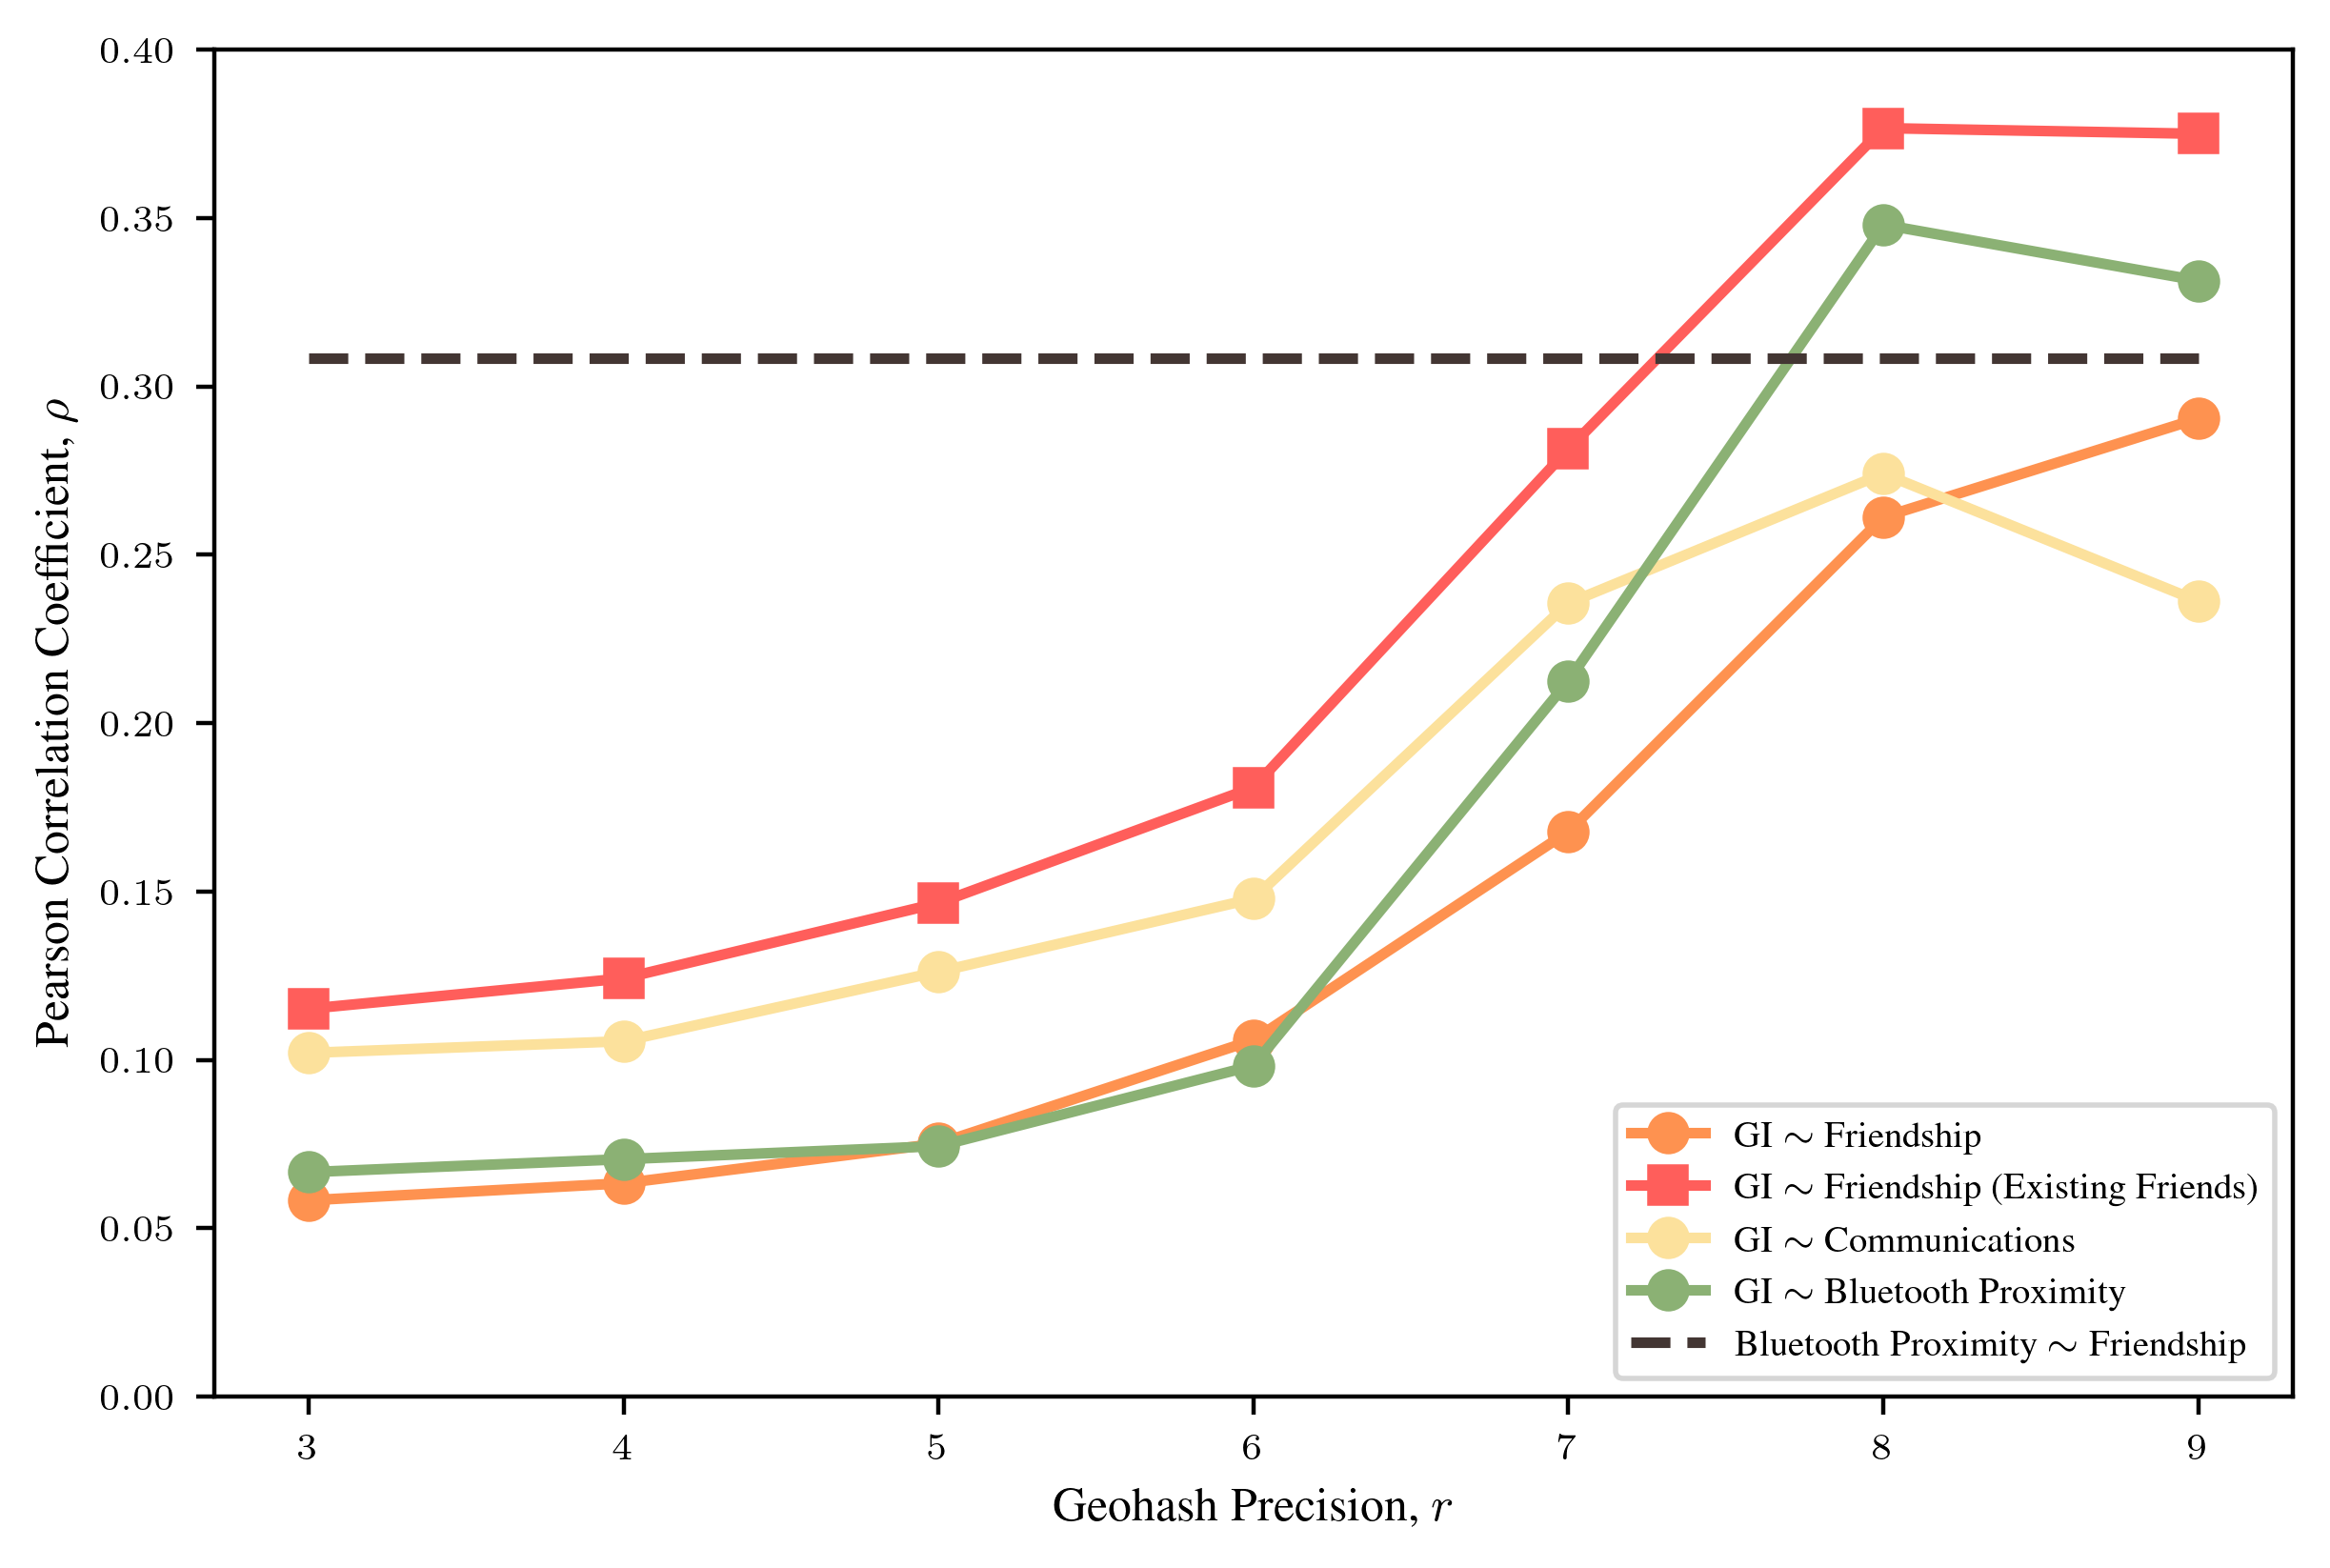

In [19]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(6, 4))
plot_performance_graph(ax, old=False)

In [20]:
def make_map_plot(ax, old=True):
    # Plot
    layers = plot(
        center, radius = radius,
        ax = ax,
        layers = {
            'perimeter': {'circle': False, 'dilate': dilate},
            'streets': {
                'width': {
                    'primary': 5,
                    'secondary': 4,
                    'tertiary': 3,
                    'residential': 2,
                    'footway': 1,
                },
                'circle': False,
                'dilate': dilate
            },
            'building': {
                'tags': {'building': True},
                'union': False,
                'circle': False,
                'dilate': dilate
            },
            'green': {
                'tags': {
                    'landuse': ['grass', 'village_green'],
                    'leisure': 'park'
                },
                'circle': False,
                'dilate': dilate
            },
        },
    drawing_kwargs = {
                'perimeter': {'fill': False, 'lw': 0, 'zorder': 0},
                'background': {'fc': background_c, 'zorder': -1},
                'green': {'fc': c5, 'ec': c3, 'lw': 1, 'zorder': 1}, # 'hatch_c': '#A7C497', 'hatch': 'ooo...', 
                'forest': {'fc': '#64B96A', 'ec': c3, 'lw': 1, 'zorder': 2},
                'water': {'fc': '#a8e1e6', 'ec': c3, 'hatch_c': '#9bc3d4', 'hatch': 'ooo...', 'lw': 1, 'zorder': 3},
                'beach': {'fc': c4, 'ec': c3, 'hatch_c': '#d4d196', 'hatch': 'ooo...', 'lw': 1, 'zorder': 3},
                'parking': {'fc': background_c, 'ec': c3, 'lw': 1, 'zorder': 3},
                'streets': {'fc': c3, 'ec': '#475657', 'alpha': 1, 'lw': 0, 'zorder': 4},
                'building': {'palette': [c2], 'ec': c3, 'lw': .5, 'zorder': 5},
                
            },
        osm_credit = {'x': 0.5, 'y': 0.5, 'color': '#FFFFFF', 'zorder':-100, 'fontsize':0.5}
    )

    # # Draw left text
    # ax.text(
    #     xmin-.06*dx, ymin+.5*dy,
    #     'Barcelona, Spain',
    #     color = c3,
    #     rotation = 90,
    #     fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 35),
    # )
    # # Draw top text
    # ax.text(
    #     xmax-.35*dx, ymax+.02*dy,
    #     "41° 23′ N, 2° 11′ E",
    #     color = c3,
    #     fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 20),
    # )


    # Set bounds
    xmin, ymin, xmax, ymax = layers['perimeter'].bounds
    dx, dy = xmax-xmin, ymax-ymin
    # dx, dy = 0,0
    ax.set_xlim(xmin-.01*dx, xmax+.01*dx)
    ax.set_ylim(ymin-.01*dy, ymax+.01*dy)


    def convert_to_shitting_meters(lon, lat):
        return ((xmax - radius) - ((center[1] - lon)*111139), (ymax - radius) - (center[0]-lat)*111139)
    ctsm = convert_to_shitting_meters # Rename for convenience


    def draw_geo_border(geo, showtext=True, lw=1, color=c1):
        border = gh.bbox(geo)
        e, n = ctsm(border['e'], border['n'])
        w, s = ctsm(border['w'], border['s'])

        # Draw square around geohash
        ax.add_patch(patches.Rectangle(
            (w, s), e-w, n-s, facecolor = 'none', edgecolor = color,  lw = lw, zorder = 100))
        # Add geohash text to center
        if showtext:
            if (xmax > (w+e)/2 > xmin) and (ymax > (s+n)/2 > ymin):
                ax.text((w+e)/2, (s+n)/2, geo,color = color, ha = 'center', va = 'center', zorder = 100, fontdict={'size': 10})

    for geo in all_geohashes_to_draw_big:
        draw_geo_border(geo, showtext=False, lw=3, color=c1)

    for geo in all_geohashes_to_draw_medium:
        draw_geo_border(geo, showtext=False, lw=1, color=c1)

    for geo in all_geohashes_to_draw_small:
        draw_geo_border(geo, showtext=False, lw=0.5, color=c1)


    if old:
        # Add labels outside the axis to the right
        ax.text(0.99,0.2, '$r=8$', color = c3, transform=ax.transAxes, size=10, zorder=102)
        ax.text(0.99,0.5, '$r=7$', color = c3, transform=ax.transAxes, size=10, zorder=102)
        ax.text(0.99,0.8, '$r=6$', color = c3, transform=ax.transAxes, size=10, zorder=102)
    else:
         # Add labels outside the axis to the left
        ax.text(-0.12, 0.2, '$r=8$', color=c3, transform=ax.transAxes, size=10, zorder=102)
        ax.text(-0.12, 0.5, '$r=7$', color=c3, transform=ax.transAxes, size=10, zorder=102)
        ax.text(-0.12, 0.8, '$r=6$', color=c3, transform=ax.transAxes, size=10, zorder=102)


    # Make a polygon thr covers the whole canvas
    ymin_ax, ymax_ax = ax.get_ylim()
    xmin_ax, xmax_ax = ax.get_xlim()
    axes_polygon = Polygon([(xmin_ax-dx, ymin_ax-dy), (xmax_ax+dx, ymin_ax-dy), (xmax_ax+dx, ymax_ax+dy), (xmin_ax-dx, ymax_ax+dy)])
    perimeter_polygon = layers['perimeter']
    difference_polygon = axes_polygon.symmetric_difference(perimeter_polygon) 

    # Draw white difference_polygon on canvas 
    gpd.GeoSeries(difference_polygon).plot(color='#FFFFFF', ax=ax, zorder=101)

/Users/tobin/miniforge3/lib/python3.10/site-packages/prettymaps/fetch.py:317: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  list(lines)
/Users/tobin/miniforge3/lib/python3.10/site-packages/prettymaps/fetch.py:317: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  list(lines)
/Users/tobin/miniforge3/lib/python3.10/site-packages/prettymaps/fetch.py:222: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  multipolys = reduce(lambda x,y: x+y, [list(x) for x in multipolys]) if len(multipolys) > 0 else []
/Users/tobin/miniforge3/lib/p

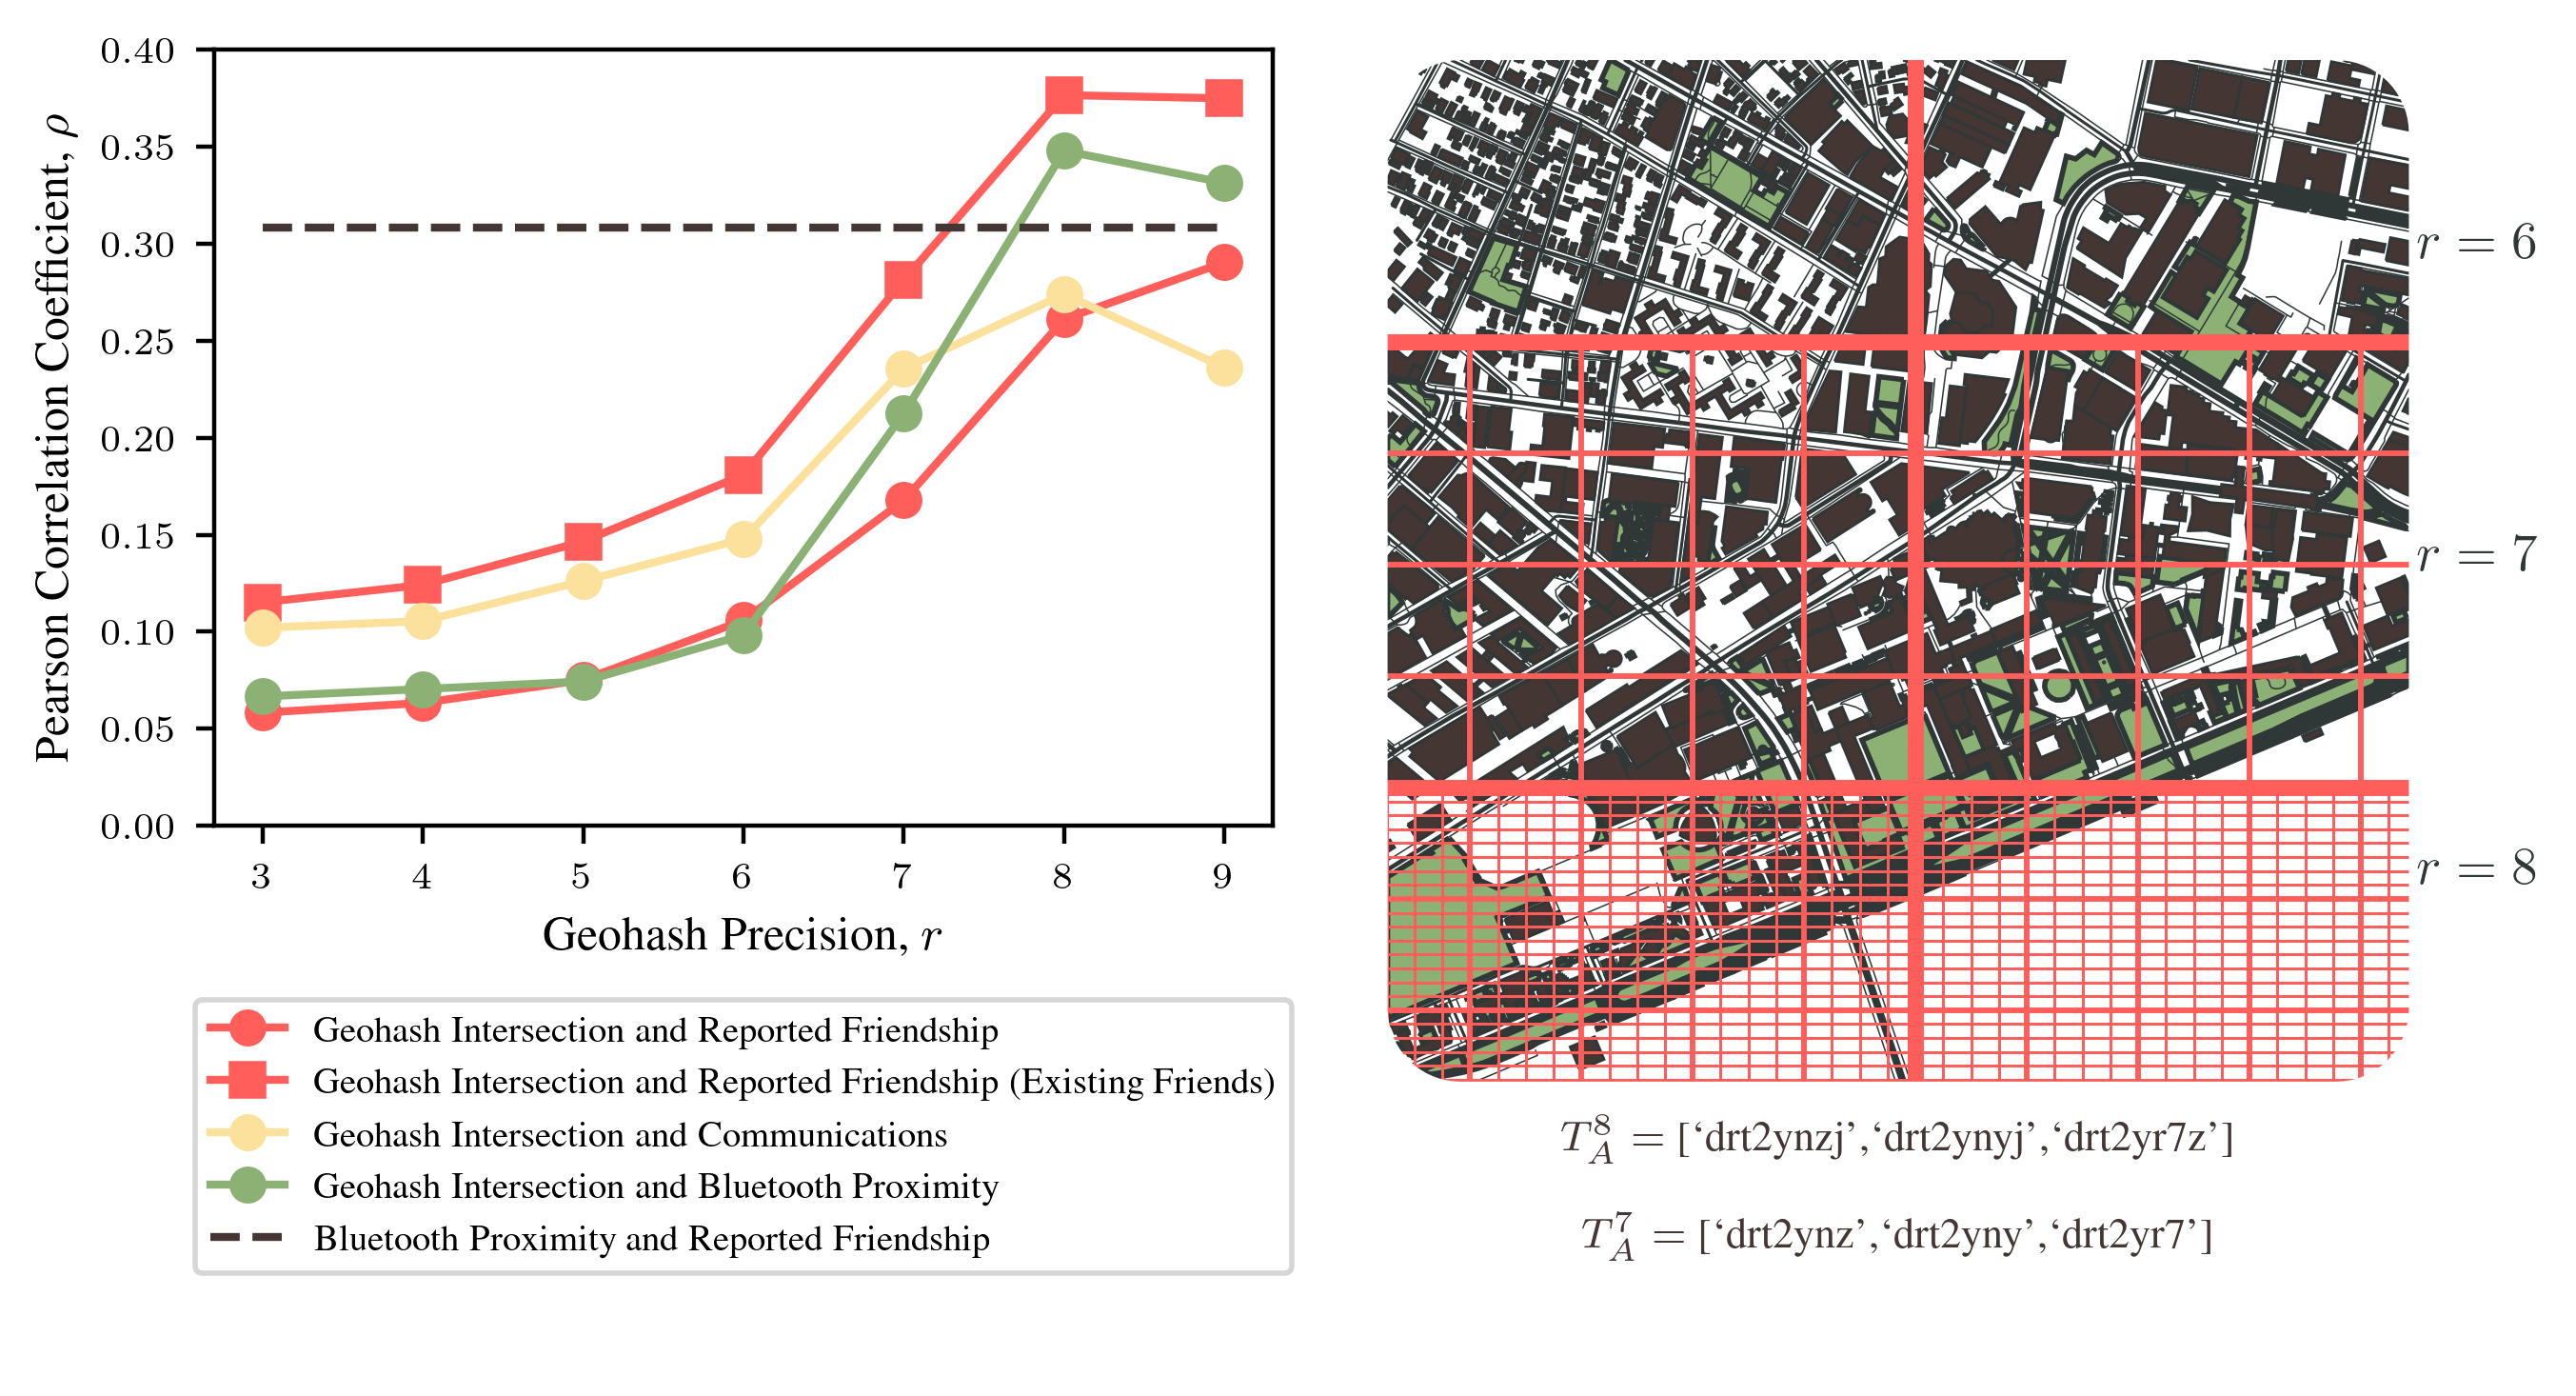

In [221]:
# Figure to combine plots
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(7.5,4.46))
gs = gridspec.GridSpec(10, 4)

ax_perform = fig.add_subplot(gs[0:6, 0:2])
plot_performance_graph(ax_perform)

ax_map = fig.add_subplot(gs[0:8, 2:4])
make_map_plot(ax_map)

ax_geohashes = fig.add_subplot(gs[8:, 2:4])
geoashs_with_arrows = ['drt2ynzj','drt2ynyj', 'drt2yr7z'] 
# ax_geohashes.text(0.5, 0.5, 'Geohashes', color = c3, transform=ax_geohashes.transAxes, size=10, zorder=102, ha='center', va='center')
ax_geohashes.text(0.5, 0.9, "$T_A^8 =$ [`" +"',`".join(geoashs_with_arrows)+"']", color = c2, transform=ax_geohashes.transAxes, size=8, zorder=102, ha='center', va='center')
ax_geohashes.text(0.5, 0.5, "$T_A^7 =$ [`" +"',`".join([g[:-1] for g in geoashs_with_arrows])+"']", color = c2, transform=ax_geohashes.transAxes, size=8, zorder=102, ha='center', va='center')

# FF5E5B

ax_geohashes.axis('off')

# arrow = patches.ConnectionPatch(
#     xyA,
#     xyB,
#     coordsA=ax1.transData,
#     coordsB=ax2.transData,
#     # Default shrink parameter is 0 so can be omitted
#     color="black",
#     arrowstyle="-|>",  # "normal" arrow
#     mutation_scale=30,  # controls arrow head size
#     linewidth=3,
# )
# fig.patches.append(arrow)

plt.tight_layout()
# plt.savefig('geohash_metaplot.pdf', bbox_inches='tight')
plt.savefig('geohash_metaplot.png', dpi=500, bbox_inches='tight')

# Combined Plot

/Users/tobin/miniforge3/lib/python3.10/site-packages/prettymaps/fetch.py:317: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  list(lines)
/Users/tobin/miniforge3/lib/python3.10/site-packages/prettymaps/fetch.py:317: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  list(lines)
/Users/tobin/miniforge3/lib/python3.10/site-packages/prettymaps/fetch.py:222: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  multipolys = reduce(lambda x,y: x+y, [list(x) for x in multipolys]) if len(multipolys) > 0 else []
/Users/tobin/miniforge3/lib/p

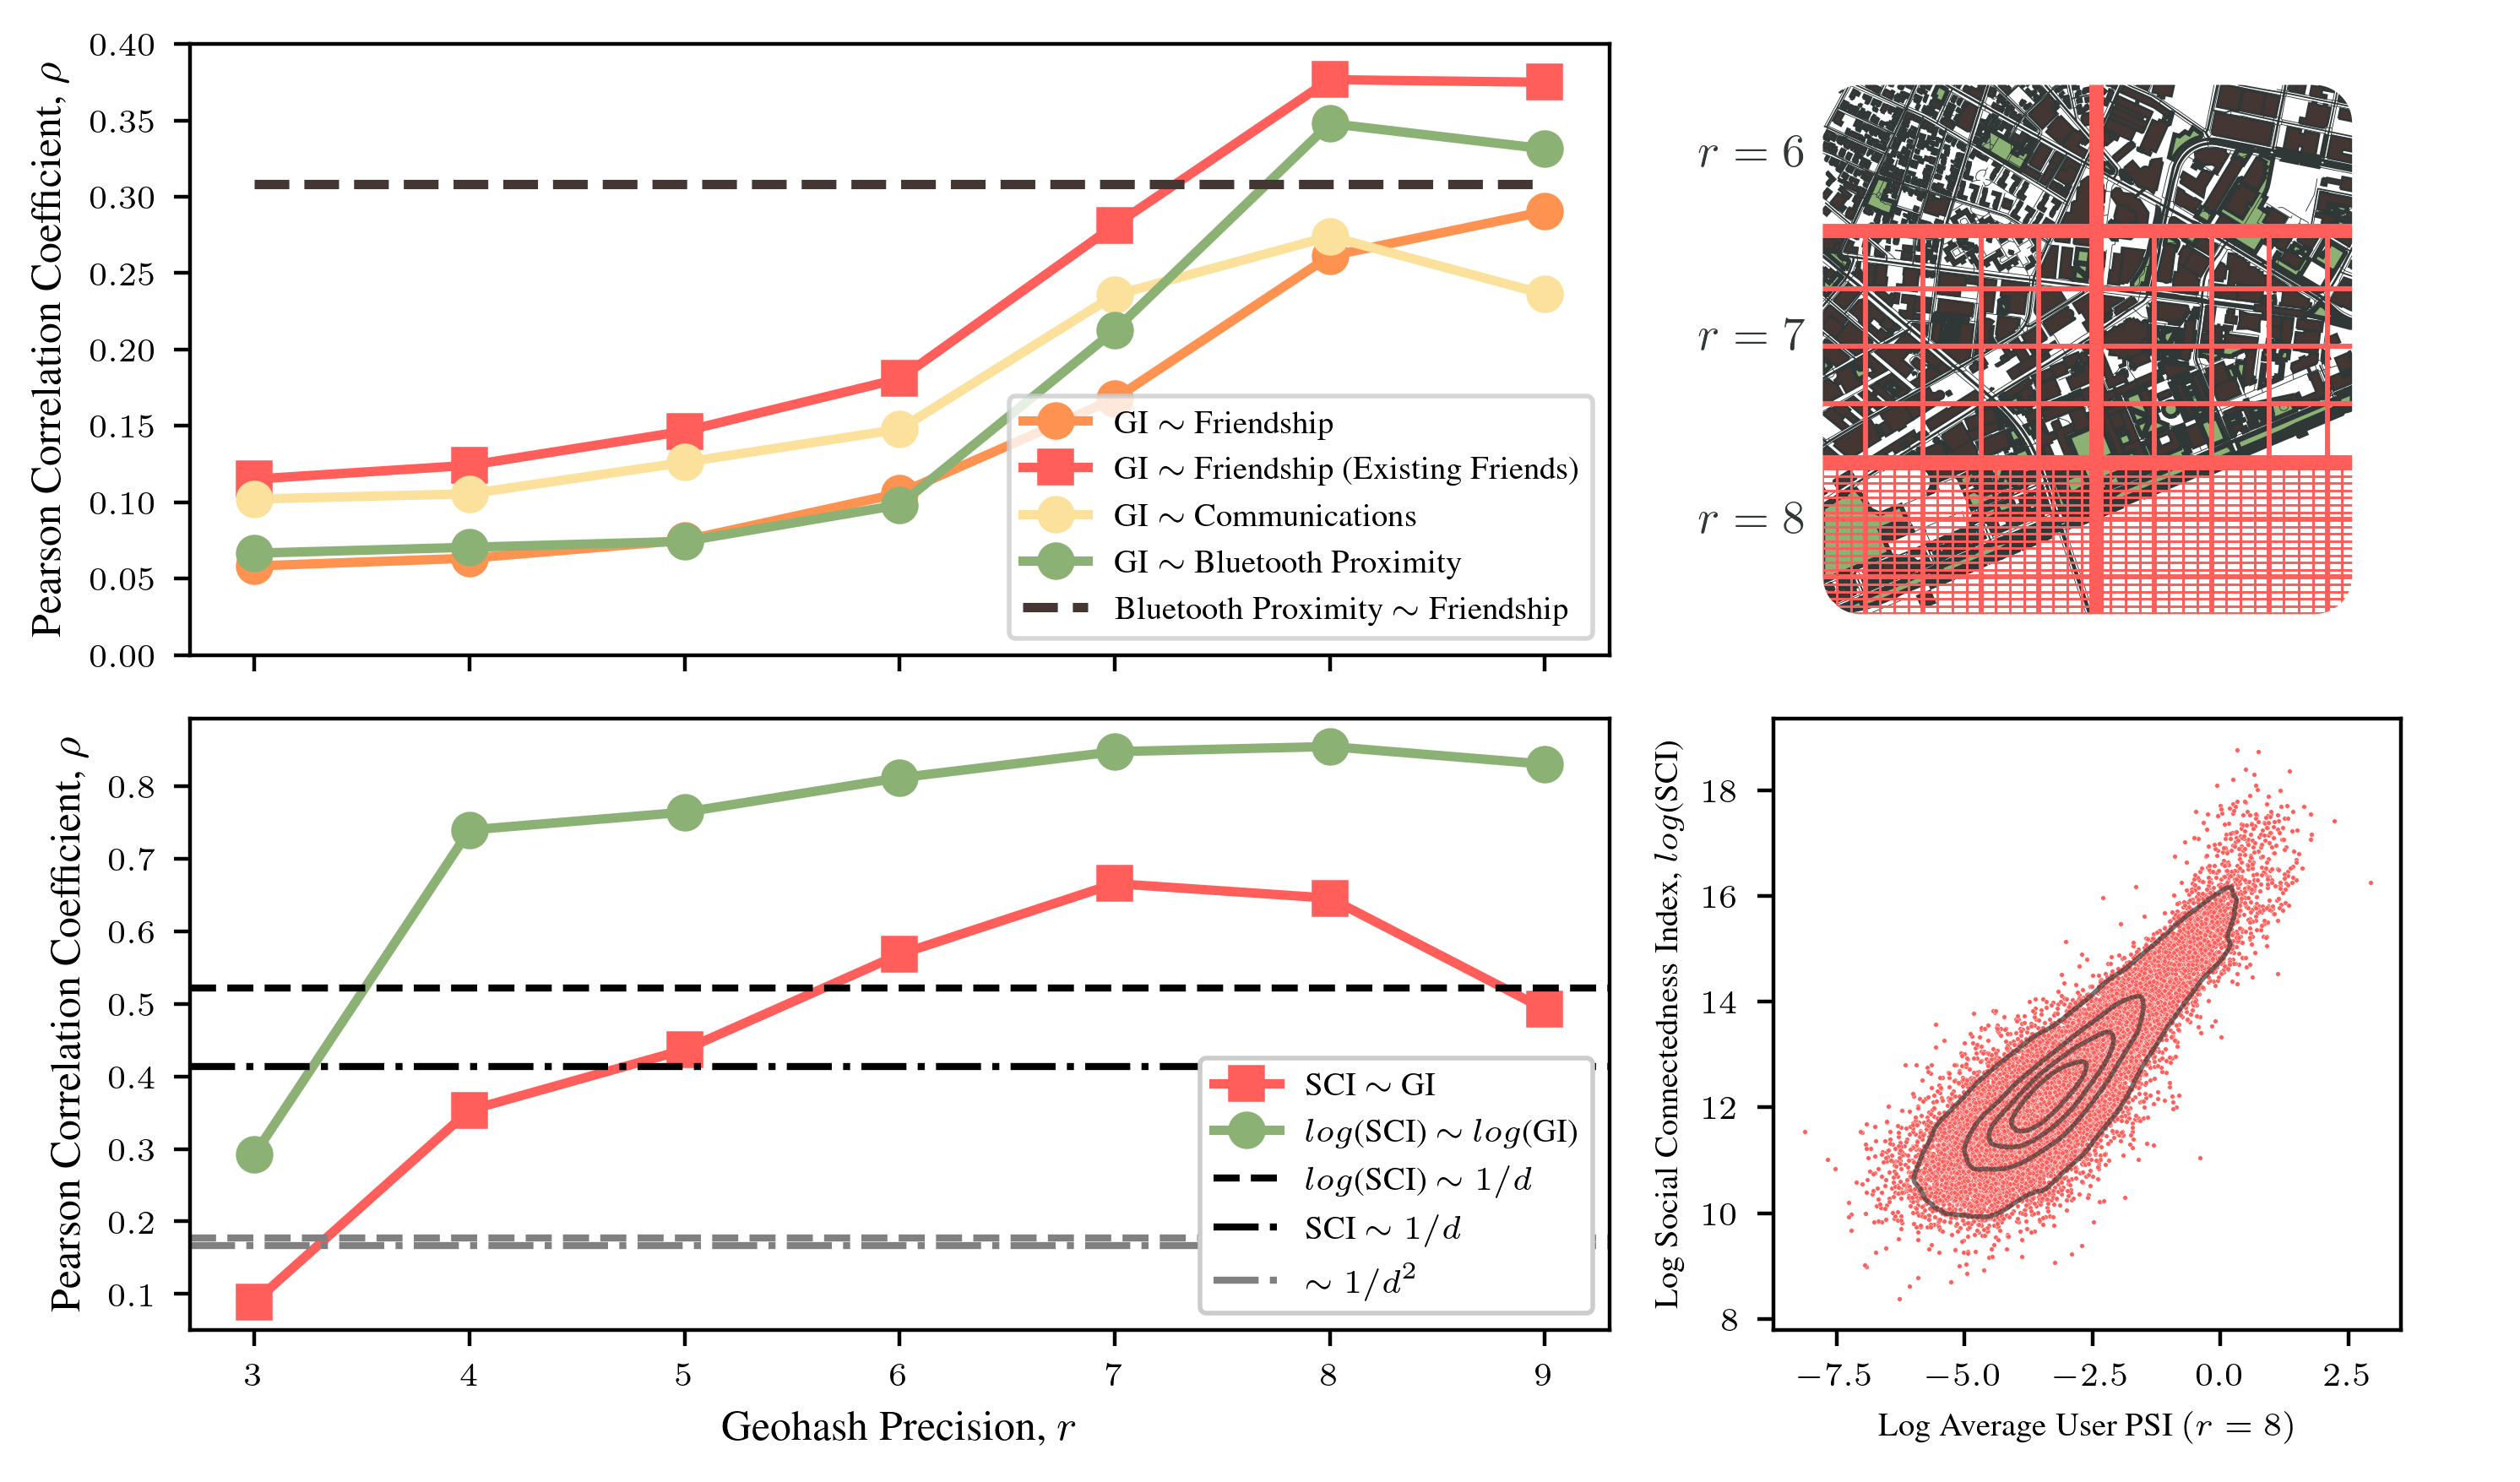

In [38]:
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(7.5,4.46))
gs = gridspec.GridSpec(2, 3)

ax_perform = fig.add_subplot(gs[0,0:2])
plot_performance_graph(ax_perform, old=False)
ax_perform.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
ax_perform.set_xlabel('')


ax_map = fig.add_subplot(gs[0,2])
make_map_plot(ax_map, old=False)

ax_psi = fig.add_subplot(gs[1,:2], sharex=ax_perform)
psi_lineplot(ax_psi)

ax_scatter = fig.add_subplot(gs[1,2])
psi_sci_scatter(ax_scatter)

plt.tight_layout()

# plt.savefig('paper_all_metaplot.png', dpi=500, bbox_inches='tight')
plt.savefig('paper_all_metaplot.pdf', bbox_inches='tight')
